### **Part 1: Prediction with LSTM**

## **CODE**

**Data Preprocesses**  


1. Data preproccessing for Part1 and Part2
2. Prepared Gold and Tesla datasets

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
   try:
     # Currently, memory growth needs to be the same across GPUs
     for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu, True)
     logical_gpus = tf.config.list_logical_devices('GPU')
     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
     # Memory growth must be set before GPUs have been initialized
     print(e)

1 Physical GPUs, 1 Logical GPUs


In [71]:
# load libraries that are necenecessary 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [140]:
#load dataset and reading 
file_path = 'Homework3 - TSLA.csv'  #file path for dataset
dataset = pd.read_csv(file_path) #read dataset as dataframe
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400


In [141]:
import yfinance as yf

# Download gold price data
gold = yf.download("GC=F", start="2010-06-29", end="2022-03-24")  # Gold futures
gold.reset_index(inplace=True)

# Save to CSV if needed
gold.to_csv("Gold_Prices.csv", index=False)

[*********************100%***********************]  1 of 1 completed


In [142]:
#read gold data
file_gold = "Gold_Prices.csv"
gold_data = pd.read_csv(file_gold)
gold_data


,Date,Close,High,Low,Open,Volume
0,NaN,GC=F,GC=F,GC=F,GC=F,GC=F
1,2010-06-29,1242.0,1245.0,1228.5,1242.0,417
2,2010-06-30,1245.5,1246.199951171875,1236.699951171875,1245.5,73
3,2010-07-01,1206.300048828125,1242.4000244140625,1204.5,1206.300048828125,50
4,2010-07-02,1207.4000244140625,1211.5999755859375,1200.800048828125,1201.4000244140625,169
...,...,...,...,...,...,...
2948,2022-03-17,1942.0999755859375,1947.199951171875,1933.9000244140625,1933.9000244140625,39
2949,2022-03-18,1928.199951171875,1939.300048828125,1928.199951171875,1934.5,28
2950,2022-03-21,1928.5999755859375,1928.5999755859375,1925.0,1925.4000244140625,5
2951,2022-03-22,1920.699951171875,1920.699951171875,1920.699951171875,1920.699951171875,26


In [143]:
#tesla and gold data merged for same size dataset
combined_dataset = pd.merge(dataset, gold_data, on="Date")
combined_dataset

,Date,Open_x,High_x,Low_x,Close_x,Adj Close,Volume_x,Close_y,High_y,Low_y,Open_y,Volume_y
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1242.0,1245.0,1228.5,1242.0,417
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,1245.5,1246.199951171875,1236.699951171875,1245.5,73
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,1206.300048828125,1242.4000244140625,1204.5,1206.300048828125,50
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,1207.4000244140625,1211.5999755859375,1200.800048828125,1201.4000244140625,169
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,1194.800048828125,1211.800048828125,1190.5,1207.300048828125,52
...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2022-03-17,830.989990,875.000000,825.719971,871.599976,871.599976,22194300,1942.0999755859375,1947.199951171875,1933.9000244140625,1933.9000244140625,39
2948,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500,1928.199951171875,1939.300048828125,1928.199951171875,1934.5,28
2949,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200,1928.5999755859375,1928.5999755859375,1925.0,1925.4000244140625,5
2950,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500,1920.699951171875,1920.699951171875,1920.699951171875,1920.699951171875,26


**Data Review** 

1. Data Loading and Reading
2. Data Visualization

In [144]:
#selected only tesla data 
tsla_data = combined_dataset.iloc[:, :7]
tsla_data

,Date,Open_x,High_x,Low_x,Close_x,Adj Close,Volume_x
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2947,2022-03-17,830.989990,875.000000,825.719971,871.599976,871.599976,22194300
2948,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2949,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2950,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


In [145]:
tsla_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2952 non-null   object 
 1   Open_x     2952 non-null   float64
 2   High_x     2952 non-null   float64
 3   Low_x      2952 non-null   float64
 4   Close_x    2952 non-null   float64
 5   Adj Close  2952 non-null   float64
 6   Volume_x   2952 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.6+ KB


In [146]:
#close column selected to analyze stock prices.
close_data = tsla_data[['Close_x']].values

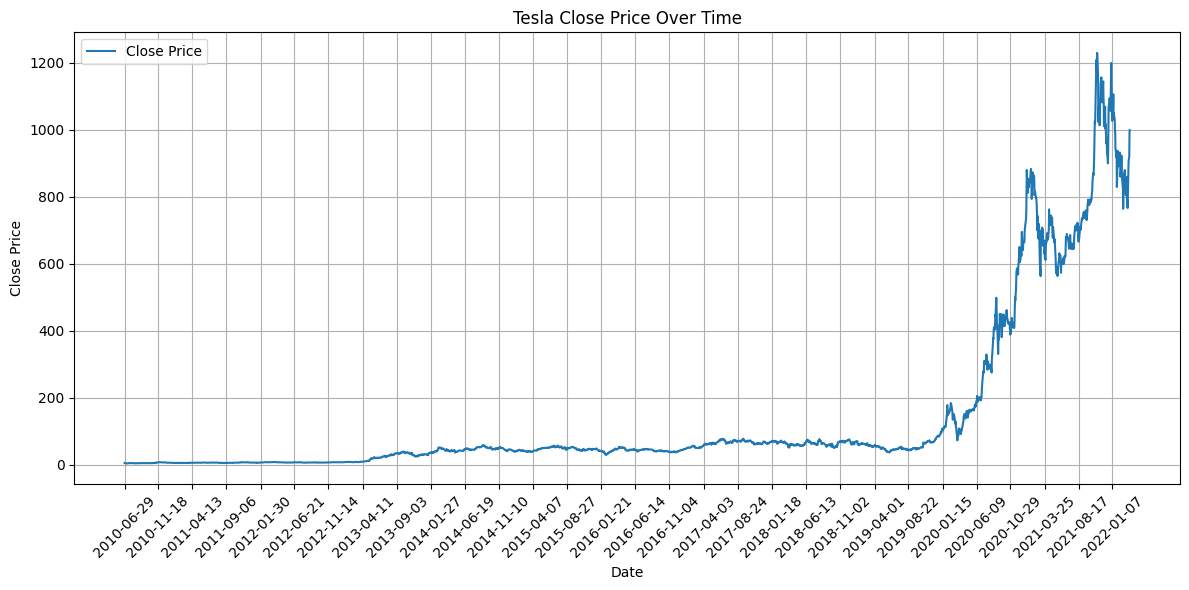

In [147]:
#dataset visualization for close column according to dates
dates = pd.to_datetime(tsla_data['Date']) #convert time format for date column 
# Every 100 days
split_dates = list(range(0, len(dates), 100))  #select every 100 day indices
split_dates = dates.iloc[split_dates] 

plt.figure(figsize=(12, 6))  
plt.plot(dates, close_data, label='Close Price')  # X: Date, Y: Close

#To set the labels to be displayed on the X-axis
plt.xticks(ticks=split_dates, labels=split_dates.dt.strftime('%Y-%m-%d'), rotation=45) #year,month,day

plt.title("Tesla Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()  
plt.show()


**Data Preprocessing**  

1. Data Scaling
2. Preparing Training and Test Data

In [148]:
#normalization and split data for preprocessing model training
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(dataset)

def split_data(dataset):
    split_training = int(len(dataset) * 0.70)  
    train, test = dataset[:split_training, :], dataset[split_training:, :]
    return train, test , split_training


In [149]:
scaled_close = scale_data(close_data)

In [150]:
train, test, split_training = split_data(scaled_close)

In [151]:
# Define a function to generated windown for features and targets
def dataset_generate(dataset, step_size):
    input_values = [] # x_train, x_test
    output_values = [] #y_train, y_test
    for i in range(len(dataset) - step_size - 1):
        x = dataset[i:(i + step_size), :]  # Input data (features)
        input_values.append(x)
        y = dataset[i + step_size, 0]
        output_values.append(y)  # Output data (target)
    return np.array(input_values), np.array(output_values)
    

In [152]:
step_size = 10 #predict for each 10 data hat comes previous 
x_train, y_train = dataset_generate(train, step_size)
x_test, y_test = dataset_generate(test, step_size)

In [153]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2055, 10, 1)
(2055,)
(875, 10, 1)
(875,)


**Long Short Term Memory**  

1. LSTM model 
2. Model Compile and Fit
3. Model Prediction
4. Model Evaluation
5. Result Visualization
   

In [490]:
#model generated
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(10, 1)),  
    tf.keras.layers.LSTM(50, return_sequences=False),  
    tf.keras.layers.Dense(25), 
    tf.keras.layers.Dense(1)  
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_18 (LSTM)              (None, 50)                20200     
                                                                 
 dense_175 (Dense)           (None, 25)                1275      
                                                                 
 dense_176 (Dense)           (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [155]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=0)


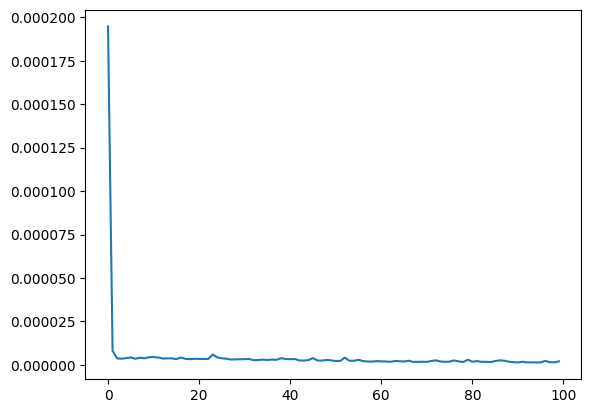

In [489]:
plt.plot(history.history["loss"])

In [229]:
# values convert original values 
def scale_transform_data(train_pred,test_pred):

    # Inverse transform to original scale
    train_predict = scaler.inverse_transform(
        np.concatenate((train_pred.reshape(-1, 1), np.zeros_like(train_pred).reshape(-1, 1)), axis=1))[:, 0]
    
    test_predict= scaler.inverse_transform(
        np.concatenate((test_pred.reshape(-1, 1), np.zeros_like(test_pred).reshape(-1, 1)), axis=1))[:, 0]

    return train_predict ,test_predict 

In [222]:
# Predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

x_train_pred , x_test_pred = scale_transform_data(train_pred,test_pred)

28/28 [==============================] - 0s 7ms/step


In [223]:
#model evaluation
evaluation = model.evaluate(x_test, y_test, verbose=1)
print(f"Result of Model Evaluation:{evaluation}")

28/28 [==============================] - 0s 9ms/step - loss: 7.6478e-04
Result of Model Evaluation:0.0007647786987945437


In [168]:
def plot_results(step_size,train_pred, test_pred,dataset):
    # Plot the actual price, training predictions, and test predictions
    plt.figure(figsize=(16, 8))
    
    train = range(step_size, step_size + len(train_pred))
    test = range(split_training + step_size, split_training + step_size + len(test_pred))
    
    plt.plot(dataset, label='Actual Price', color='blue')
    
    plt.plot(train, train_pred, label='Training Predictions', color='orange')
    
    plt.plot(test, test_pred, label='Test Predictions', color='green')
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Tesla Stock Price Predictions')
    plt.legend()
    plt.show()


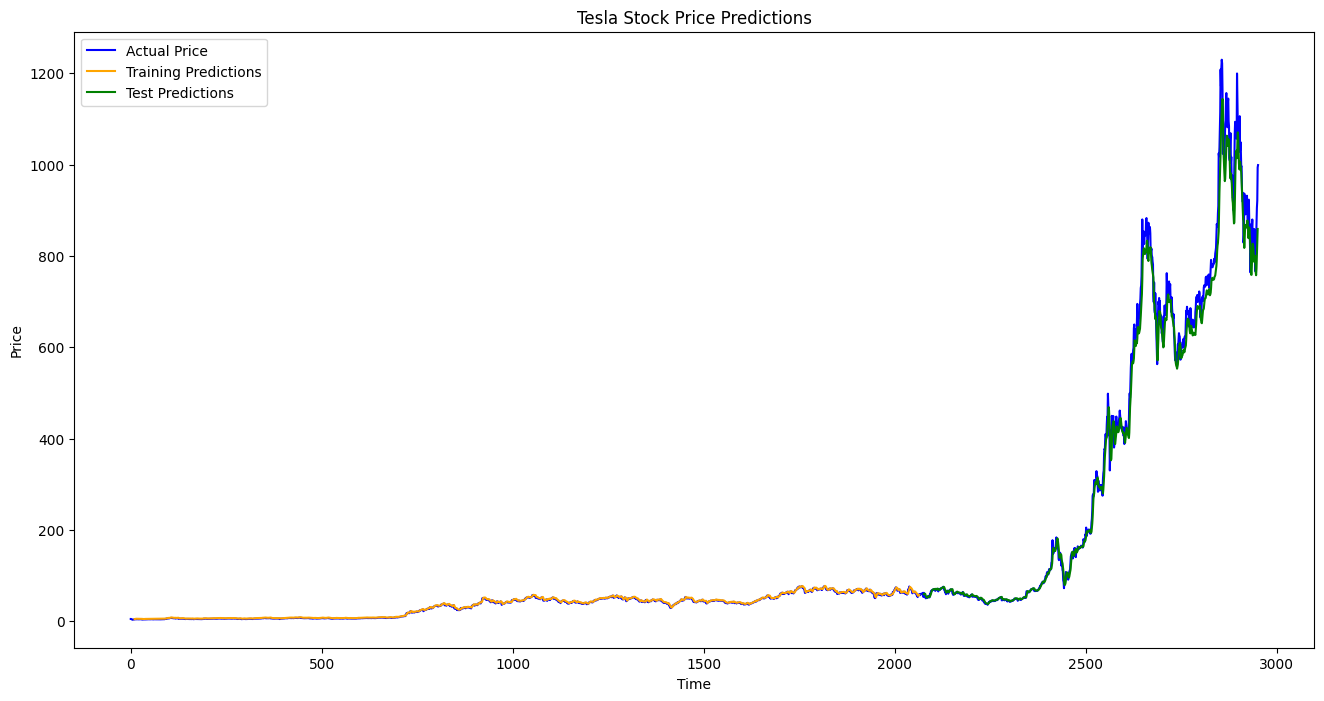

In [225]:
plot_results(step_size,x_train_pred,x_test_pred,close_data)

In [170]:
model.save("LSTM_model.h5")

**Long Short Term Memory**  

1. Additional feature (Gold Price)
2. Repeat LSTM Model
3. Report the Performance of Model
4. Result Visualization

In [171]:
# Select the close price of TSLA and gold price as features
close_gold_tsla = combined_dataset[['Close_x', 'Close_y']].values


In [172]:
scaled_features = scale_data(close_gold_tsla)

In [173]:
train_multi, test_multi, split_training_multi = split_data(scaled_features)

In [174]:
x_train_multi, y_train_multi = dataset_generate(train_multi, step_size)
x_test_multi, y_test_multi = dataset_generate(test_multi, step_size)

In [175]:
print(x_train_multi.shape)
print(x_test_multi.shape)
print(y_train_multi.shape)
print(y_test_multi.shape)

(2055, 10, 2)
(875, 10, 2)
(2055,)
(875,)


In [491]:
model_multi = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(10, 2)),  
    tf.keras.layers.LSTM(50, return_sequences=False),  
    tf.keras.layers.Dense(25), 
    tf.keras.layers.Dense(1)  
])
model_multi.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 10, 50)            10600     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_177 (Dense)           (None, 25)                1275      
                                                                 
 dense_178 (Dense)           (None, 1)                 26        
                                                                 
Total params: 32,101
Trainable params: 32,101
Non-trainable params: 0
_________________________________________________________________


In [177]:
# Compile the model
model_multi.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history_multi = model_multi.fit(x_train_multi, y_train, validation_data=(x_test_multi, y_test), epochs=100, batch_size=64, verbose=0)

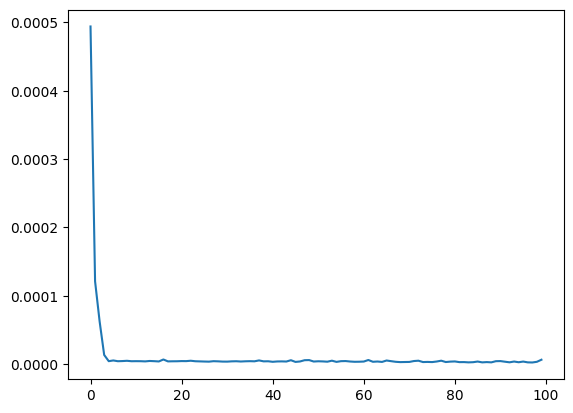

In [488]:
plt.plot(history_multi.history["loss"])

In [231]:
train_predict_multi = model_multi.predict(x_train_multi)
test_predict_multi = model_multi.predict(x_test_multi)

28/28 [==============================] - 0s 8ms/step


In [232]:
x_train_pred_multi , x_test_pred_multi = scale_transform_data(train_predict_multi,test_predict_multi)

In [233]:
evaluation = model_multi.evaluate(x_test_multi, y_test_multi, verbose=1)
print(f"Result of Model Evaluation:{evaluation}")

28/28 [==============================] - 0s 10ms/step - loss: 0.0032
Result of Model Evaluation:0.0031589169520884752


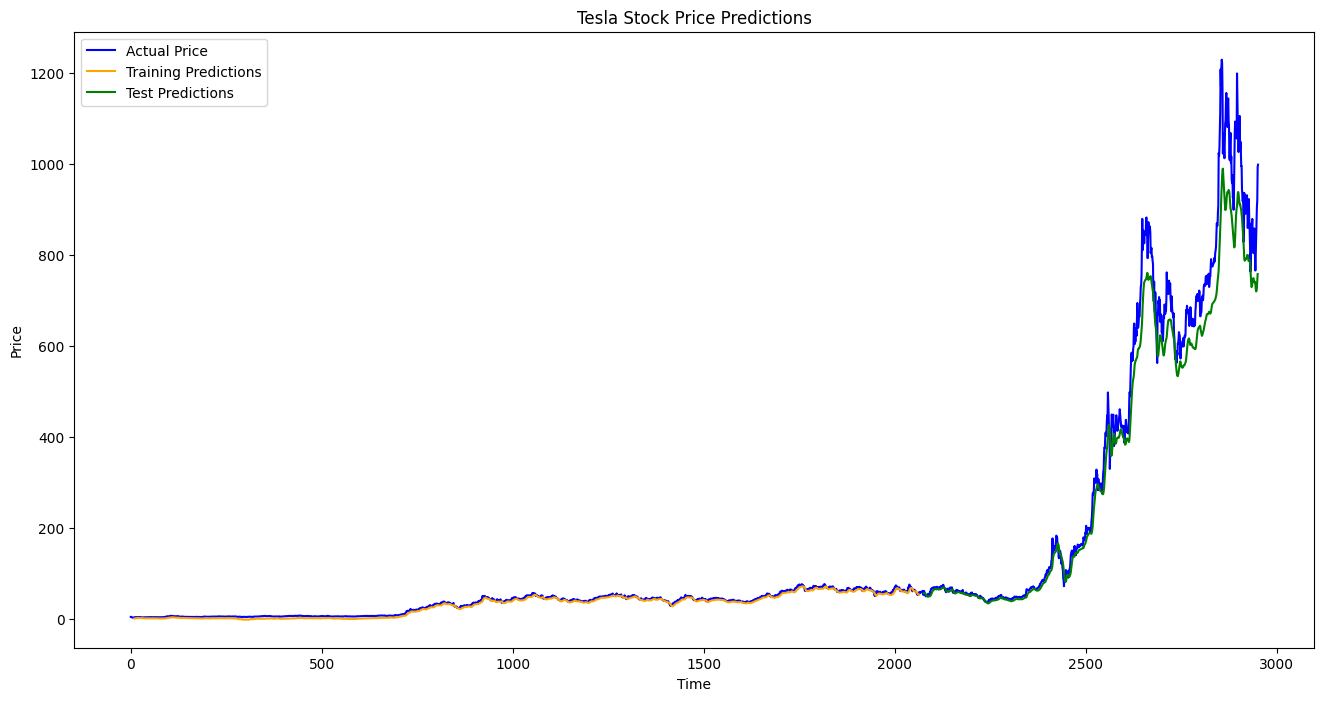

In [234]:
plot_results(step_size,x_train_pred_multi,x_test_pred_multi,close_data)

In [183]:
model_multi.save("LSTM_multi_model.h5")

## **RESULTS**

In this section, LSTM model was created using stock market prediction for Tesla. Dataset was loaded and read from **TSLA.csv** file. Create a new dataset for an additional feature including gold prices and merge it with Tesla dataset because this section uses each dataset for LSTM model. First model has closing data only from Tesla dataset while second model has closing data from Tesla and gold dataset. Tesla Dataset has 7 columns as **Date, Open, High, Low, Close, Adjusted Close, Volume** and closing column selected for LSTM model. Graph created using date and closing values. Closing data was scaled in **[0,1]** range using **MinMaxScaler** function. First 70 percent of data was used for train data and the rest for test data. A function was written and x and y values were created for both train and test data. This function creates a value every 10 days. The LSTM model consists of 2 LSTM layers and 2 dense layers. There are 50 nodes in the LSTM layers. There are 25 nodes in one of the dense layers and 1 node as the output layer in the other. When the result of the model summary is examined, it is seen that there are **31,901** trainable parameters. The **adam** optimizer was used while compiling the model and **mean squared error** was used as the loss function. Model training was performed with **100 epochs** and **64 batch size**. Using the model, the training and test data were entered into the estimation process and the obtained results were returned to their original values with the **inverse transformation** function since they were previously normalized. The model was evaluated and a loss value of **0.0007** was obtained. The real price, that is, the real values in the close column in the data, are the values obtained after the estimation process of the training values and the test values. It was plotted with a graph. In the combined data set (Tesla and Gold data set), the same operations were performed using the close columns. In these processes, the scaling process was performed by placing the close column values for Tesla and the close column values for gold in a separate variable, then 70% and 30% were separated to create training and test data sets. The input shape was different from the previous model when creating the model. The previous modeled input shape was **10.1**, while it became **10.2** in this model. The loss value obtained as a result of the model evaluation was **0.0031**. The same processes were repeated and the results were converted into a graph.

## **COMMENTS**

The Tesla data content was examined and it was observed that there were increases in close price values after 2020. The model we prepared was aimed to predict this increase correctly. The Tesla data and gold data contained small differences in the number of rows, so first these two data were combined, missing data were eliminated and the same amount of Tesla and gold close price values were created. These values were brought to the 0.1 range with normalization, thus obtaining more useful data when training the model. The LSTM model prepared only for Tesla close price values is a simple model consisting of 2 LSTM layers and 2 dense layers. After evaluating several different combinations by making changes to the model, it was observed that the best result was obtained with this model. The model works quite fast. The loss value obtained after the model evaluate was also quite low as desired. The obtained results were shown graphically and it was observed that the test values predicted the real values quite well. When the model evaluate result prepared with the close price values in both the Tesla and gold data set was examined, a higher loss value was obtained compared to the previous model, but still a low loss value was observed. When the model's graph is examined, the predictions were slightly below the actual predictions compared to the previous model, but they gave results that were quite compatible with the increases and decreases of the values in the graph.

### **Part 2: Prediction with Transformers**

**LSTM with Transformer (Only Tsla Data Close)**  

1. Transformer Encoder Layer
2. Build Model
3. Model fitting
4. Model Evaluate
5. Result Visualization

In [354]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", 
                    kernel_regularizer=regularizers.l2(0.01))(res)  # L2 regularization added
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

inputs = layers.Input(shape=(10, 1))
x = transformer_encoder(inputs, head_size=128, num_heads=12, ff_dim=128, dropout=0.3)
x = transformer_encoder(x, head_size=128, num_heads=12, ff_dim=128, dropout=0.3)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_transformers = tf.keras.Model(inputs, outputs)
optimizer = Adam(learning_rate=0.001)
model_transformers.compile(optimizer=optimizer, loss='mean_squared_error')

#early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6)
]
model_transformers.summary()


history_transformer = model_transformers.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=callback, epochs=200, batch_size=64, verbose=0)

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 multi_head_attention_49 (Multi  (None, 10, 1)       10753       ['input_29[0][0]',               
 HeadAttention)                                                   'input_29[0][0]']               
                                                                                                  
 dropout_116 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_49[0][0]']
                                                                                                  
 layer_normalization_95 (LayerN  (None, 10, 1)       2           ['dropout_116[0][0]']     

In [355]:
train_predict_transformer = model_transformers.predict(x_train)
test_predict_transformer = model_transformers.predict(x_test)

28/28 [==============================] - 1s 22ms/step


In [356]:
x_train_pred_transformer , x_test_pred_transformer = scale_transform_data(train_predict_transformer,test_predict_transformer)

In [357]:
evaluation = model_transformers.evaluate(x_test, y_test, verbose=1)
print(f"Result of Model Evaluation:{evaluation}")

28/28 [==============================] - 1s 19ms/step - loss: 0.0021
Result of Model Evaluation:0.002103180857375264


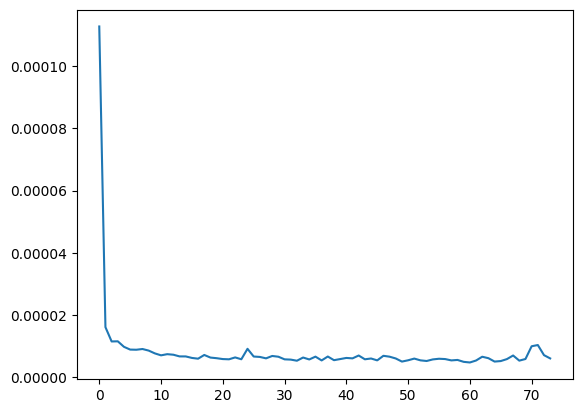

In [358]:
plt.plot(history_transformer.history["loss"])

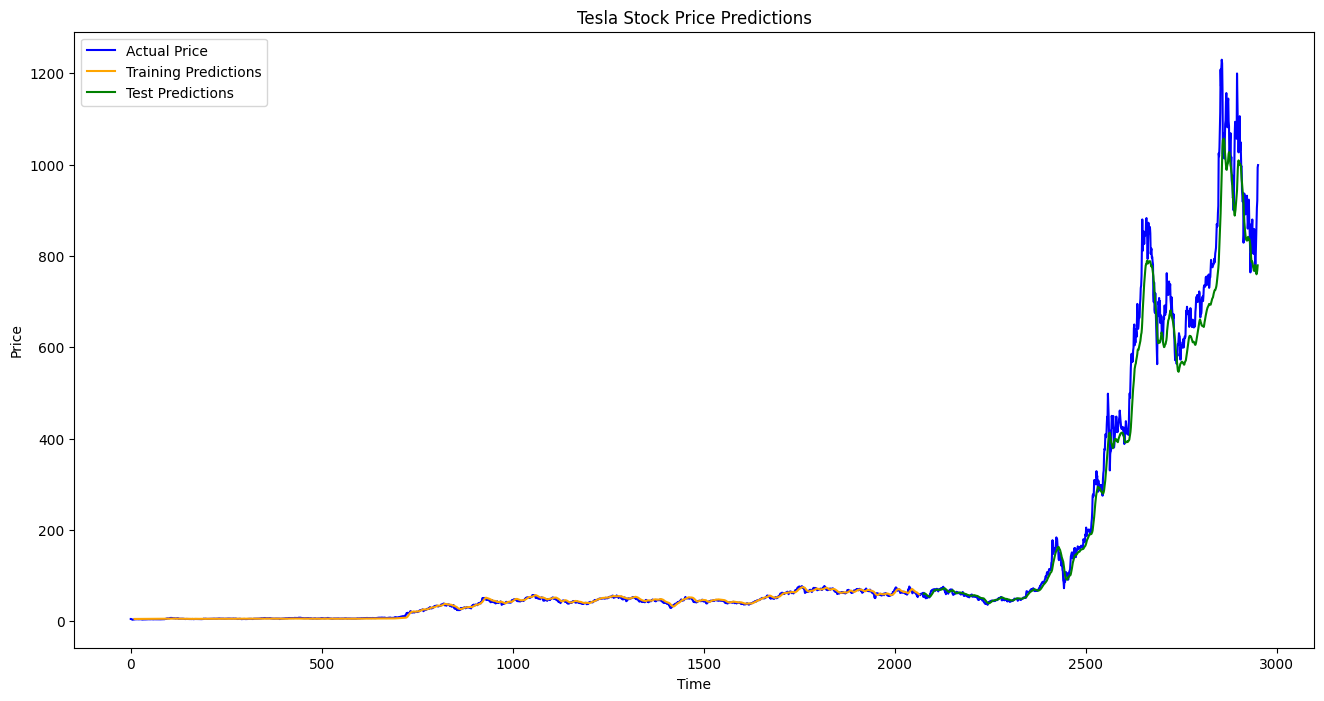

In [359]:
plot_results(step_size,x_train_pred_transformer,x_test_pred_transformer,close_data)

In [486]:
model_transformers.save("LSTM_with_Transformers.h5")

**LSTM with Transformer (Tsla and Gold Data Close)**  

1. Transformer Encoder Layer
2. Build Model
3. Model fitting
4. Model Evalaute
5. Result Visualization

In [480]:
inputs = layers.Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=8, ff_dim=128, dropout=0.2)
x = transformer_encoder(inputs, head_size=256, num_heads=8, ff_dim=128, dropout=0.1)
x = transformer_encoder(inputs, head_size=128, num_heads=8, ff_dim=64, dropout=0.1)
x = transformer_encoder(inputs, head_size=128, num_heads=8, ff_dim=64, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)  
outputs = layers.Dense(1)(x)

model_multi_transformer = tf.keras.Model(inputs, outputs)
optimizer = Adam(learning_rate=0.001)
model_multi_transformer.compile(optimizer=optimizer, loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6)
]
model_multi_transformer.summary()


history_multi_transformer = model_multi_transformer.fit(x_train_multi, y_train, validation_data=(x_test_multi, y_test), callbacks=callback, epochs=200, batch_size=64, verbose=0)

Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 10, 2)]      0           []                               
                                                                                                  
 multi_head_attention_126 (Mult  (None, 10, 2)       11266       ['input_50[0][0]',               
 iHeadAttention)                                                  'input_50[0][0]']               
                                                                                                  
 dropout_291 (Dropout)          (None, 10, 2)        0           ['multi_head_attention_126[0][0]'
                                                                 ]                                
                                                                                           

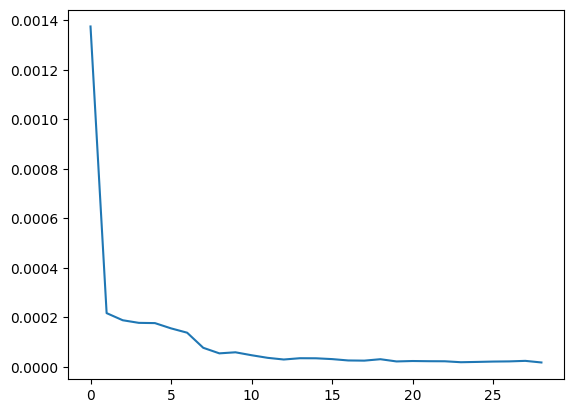

In [481]:
plt.plot(history_multi_transformer.history["loss"])

In [482]:
train_pred_transformer_multi = model_multi_transformer.predict(x_train_multi)
test_pred_transformer_multi = model_multi_transformer.predict(x_test_multi)

28/28 [==============================] - 0s 8ms/step


In [483]:
x_train_pred_transformer_multi , x_test_pred_transformer_multi = scale_transform_data(train_pred_transformer_multi,test_pred_transformer_multi)

In [484]:
evaluation = model_multi_transformer.evaluate(x_test_multi, y_test_multi, verbose=1)
print(f"Result of Model Evaluation:{evaluation}")

28/28 [==============================] - 0s 12ms/step - loss: 0.1063
Result of Model Evaluation:0.10626132786273956


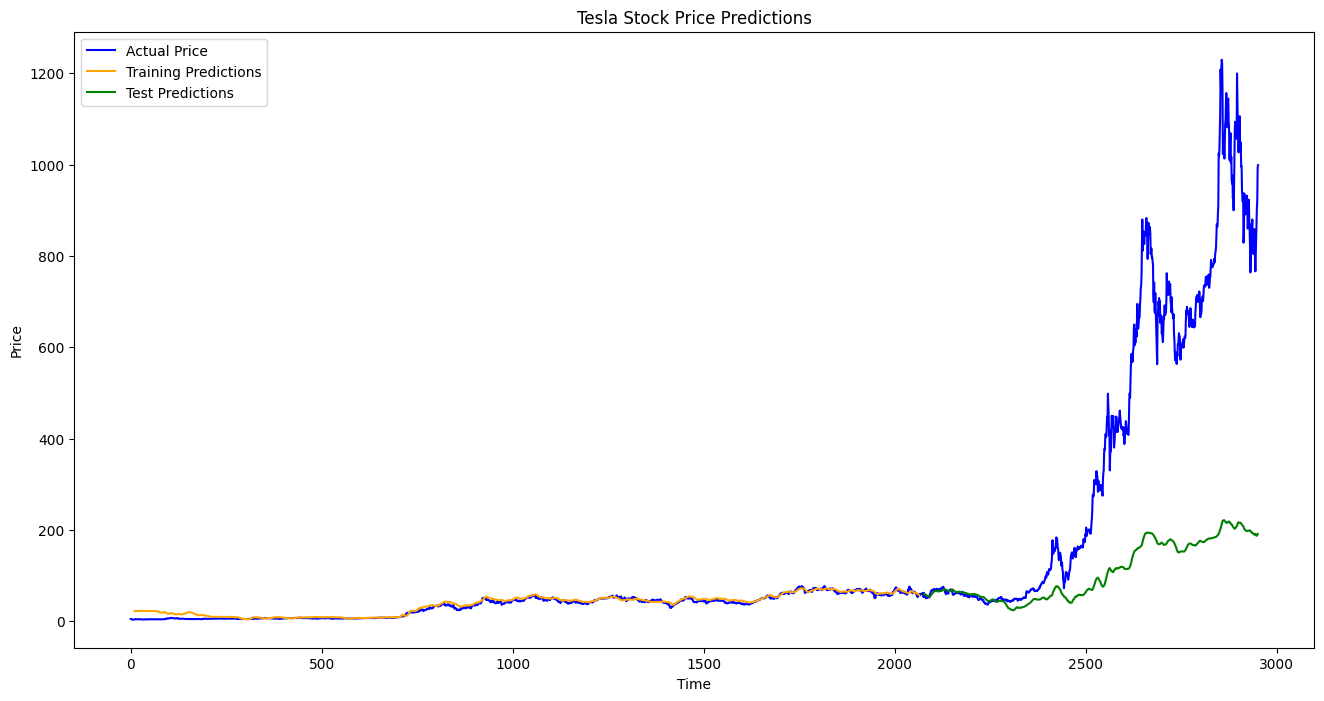

In [485]:
plot_results(step_size,x_train_pred_transformer_multi,x_test_pred_transformer_multi,close_data)

In [487]:
model_multi_transformer.save("LSTM_with_Transfomer_multidata.h5")

## **RESULTS**

The LSTM model was created using the close price values in the Tesla dataset, but this time modeled transformers were used. Transformers are a model architecture used for sequential data processing in deep learning. LSTM uses the cell state to keep past information in memory, but this information can be lost in very long sequences, at this point it can learn long-term dependencies thanks to transformers. A deep learning model that includes a transformer encoder block was defined for this part. In this block, head size is the size for each head in the attention mechanism, num_heads is the number of multiple heads, and ff_dim is the term used for feef forward network size. In this architecture, **multiHeadAttention** is useful for learning the relationships of each element in the input with other elements. Normalization and regularization methods were applied to increase stability in the model. Two transformer encoder blocks were used to learn more complex relationships while creating the model. **head size 128, num_heads 12, ff_dim 123 , dropout rate was set as 0.3**. These values were created with the best combinations by analyzing the output of the model through trials. With **GlobalAveragePooling1D**, the data was compressed with the average in the time axis and an additional vector was created. For dense layers, **relu** was used with the activation function and 2 dense layers were created, one with **128** neurons and the other with **64**. **Adam** optimizer was used to compile the model and the learning rate was set to **0.001**, and **mean squared error** was used as the loss function for regression problems. Callbacks were added for training, patience was set to **20**. In this way, during training, validation loss improvement, training is stopped early and the number of unnecessary epochs is adjusted in a controlled manner. With the **ReduceLROnPlateu** function, if the validation loss is not improved, the learning rate is reduced. This model has **30.861** trainable params. As a result of the model evaluation, the loss value was found to be **0.0021**. When the model result was graphed, it was seen that the test prediction results were quite close to the close price values.

Then, for the data set where the close price values for both Tesla and Gold data were used together, the LSTM model was prepared using a transformer. The input shape in the model architecture was arranged accordingly. 4 transformer encoder layers were used for this data set. In the first layer, it was prepared with the values **head size 256, num heads 8, ff dim 128** and a dropout of **0.2** was added. The changes in the second layer changed the dropout rate to **0.1**. In the third and fourth layers, it was prepared with the values **head size 128, num head 8, ff dim 64, dropout 0.1**. It was prepared with 3 dense layer relu function and 128 neurons. After performing model training, it was seen that the model evaluate value was **0.1062**. In the graph created as a result of the model, it was seen that the test prediction values were not estimated as well as other models.


## **COMMENTS**

The evaluation value of the model prepared using transformers with close price values for Tesla data is higher than the value in part 1. The LSTM model may work better on small data, but transformers perform better on larger data. Therefore, it may have performed better in part 1 in this study. The model prepared for the close price values of gold and tesla data gave the worst result among the prepared models. The absence of only tesla data in the train data with this model may have had a negative effect on the results of the model. The structure of the model may have been too complex in terms of learning the data and the dropout rates may have been insufficient. Model improvements may need to be made by optimizing the parameters for the models prepared using transformers. When Tesla and gold data were used together, it was seen that the increase directions in the test set estimates were estimated correctly, but the values were estimated quite low compared to the real values.